# Exploratory Data Analysis

This notebook performs exploratory data analysis (EDA) on the engineered dataset to better understand the data distribution, feature significance, and multicollinearity. The key steps are as follows:

1. **Normality Testing**
   - The Anderson-Darling test is applied to each numerical feature to assess whether it follows a normal distribution.
   - Results are saved in `normality_results_AD.csv`.
   - Histogram and KDE plots are generated in batches and saved in the `distribution_plots/` directory.

2. **Feature Significance Analysis**
   - The Kruskal-Wallis H Test is used to determine the statistical significance of each numerical feature in relation to the target variable (`activity`).
   - Features are categorized as significant or non-significant based on a p-value threshold of 0.05.
   - Results are saved in `kruskal_wallis_results.csv`.

3. **Multicollinearity Analysis**
   - A Pearson correlation matrix is computed (absolute values) to identify highly correlated features.
   - A heatmap is generated and saved as `correlation_heatmap.png`.

4. **Class Distribution Check**
   - The distribution of activity labels is visualized to examine class imbalance in the dataset.
   
5. **Feature Importance Check with RF**
   - The horizontal barchar shows how much the features are important, higher importance score, higher influence in predicting output column (activity).

These analyses help inform feature selection and model choice by revealing feature relevance, data distribution patterns, and potential redundancy among features.


## Normality test with One Sample Anderson-Darling test

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson
import os

# Load the dataset
df = pd.read_csv("Updated_Metadata.csv")

# Select numeric columns
numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns

# Anderson-Darling Normality Test
ad_results = {}
for col in numeric_columns:
    col_data = df[col].dropna()
    result = anderson(col_data, dist='norm')
    ad_results[col] = result.statistic < result.critical_values[2]  # 5% significance

# Create summary DataFrame
normality_df = pd.DataFrame.from_dict(ad_results, orient="index", columns=["Normal_Distribution_AD"])
normality_df["Skewness"] = df[numeric_columns].skew()
normality_df["Kurtosis"] = df[numeric_columns].kurtosis()

# Save results
normality_df.to_csv("normality_results_AD.csv")

# Create and save histogram + KDE plots in batches
batch_size = 9
total_cols = len(numeric_columns)
plot_dir = "distribution_plots"
os.makedirs(plot_dir, exist_ok=True)

for start in range(0, total_cols, batch_size):
    end = min(start + batch_size, total_cols)
    batch_columns = numeric_columns[start:end]
    ncols = 3
    nrows = (len(batch_columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, nrows * 4))
    axes = axes.flatten()

    for i, col in enumerate(batch_columns):
        sns.histplot(df[col].dropna(), bins=30, kde=True, ax=axes[i])
        axes[i].set_title(col, fontsize=10)
        axes[i].tick_params(axis='x', labelrotation=45)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plot_path = os.path.join(plot_dir, f"distribution_plots_batch_{start//batch_size + 1}.png")
    plt.savefig(plot_path, dpi=300)
    plt.close()

print("Analysis complete. Results saved in 'normality_results_AD.csv' and plots in 'distribution_plots/' directory.")


Analysis complete. Results saved in 'normality_results_AD.csv' and plots in 'distribution_plots/' directory.


After checking the statistical results and distribution plot of each feature column, the features are not normally distributed. So decided to use Kruskal-Wallis H Test to identify the most significant features related to activity.

## Perform Kruskal-Wallis H Test to identify the most significant features related to output column (activity)

In [12]:
import pandas as pd
import scipy.stats as stats

# Load the cleaned dataset
metadata_df = pd.read_csv("Updated_Metadata.csv")  # Ensure the correct file path

# Extract numerical features and the categorical target variable (activity)
numeric_columns = metadata_df.select_dtypes(include=["float64", "int64"]).columns
target_column = "activity"

# Perform Kruskal-Wallis H Test for each numerical feature against activity
kruskal_results = {}

for col in numeric_columns:
    groups = [metadata_df[col][metadata_df[target_column] == activity].dropna() for activity in metadata_df[target_column].unique()]
    stat, p_value = stats.kruskal(*groups)
    kruskal_results[col] = p_value

# Convert results into a DataFrame
kruskal_df = pd.DataFrame.from_dict(kruskal_results, orient="index", columns=["p_value"])

# Mark features as significant if p < 0.05
kruskal_df["Significant"] = kruskal_df["p_value"] < 0.05  

# Filter features
significant_features = kruskal_df[kruskal_df["Significant"]].index.tolist()
non_significant_features = kruskal_df[~kruskal_df["Significant"]].index.tolist()

# Print results
print("\nSignificant Features Based on Kruskal-Wallis Test (p < 0.05):")
print(significant_features)
print("Number of significant features:", len(significant_features))

print("\nNon-Significant Features (p >= 0.05):")
print(non_significant_features)
print("Number of non-significant features:", len(non_significant_features))

# Save the results to a CSV file
kruskal_df.to_csv("kruskal_wallis_results.csv", index=True)
print("\nKruskal-Wallis test results saved as 'kruskal_wallis_results.csv'.")



Significant Features Based on Kruskal-Wallis Test (p < 0.05):
['x-axis__sum_values', 'x-axis__median', 'x-axis__mean', 'x-axis__length', 'x-axis__standard_deviation', 'x-axis__variance', 'x-axis__root_mean_square', 'x-axis__maximum', 'x-axis__absolute_maximum', 'x-axis__minimum', 'y-axis__sum_values', 'y-axis__median', 'y-axis__mean', 'y-axis__length', 'y-axis__standard_deviation', 'y-axis__variance', 'y-axis__root_mean_square', 'y-axis__maximum', 'y-axis__absolute_maximum', 'y-axis__minimum', 'z-axis__sum_values', 'z-axis__median', 'z-axis__mean', 'z-axis__length', 'z-axis__standard_deviation', 'z-axis__variance', 'z-axis__root_mean_square', 'z-axis__maximum', 'z-axis__absolute_maximum', 'z-axis__minimum', 'x-axis__fft_peak', 'x-axis__hjorth_mobility', 'x-axis__hjorth_complexity', 'x-axis__rolling_mean', 'x-axis__rolling_std', 'x-axis__zero_crossing_rate', 'x-axis__spectral_energy', 'x-axis__spectral_entropy', 'x-axis__iqr', 'x-axis__coeff_var', 'x-axis__energy', 'x-axis_MAD', 'x-axi

## Check Multicollinearity with Pearson Method

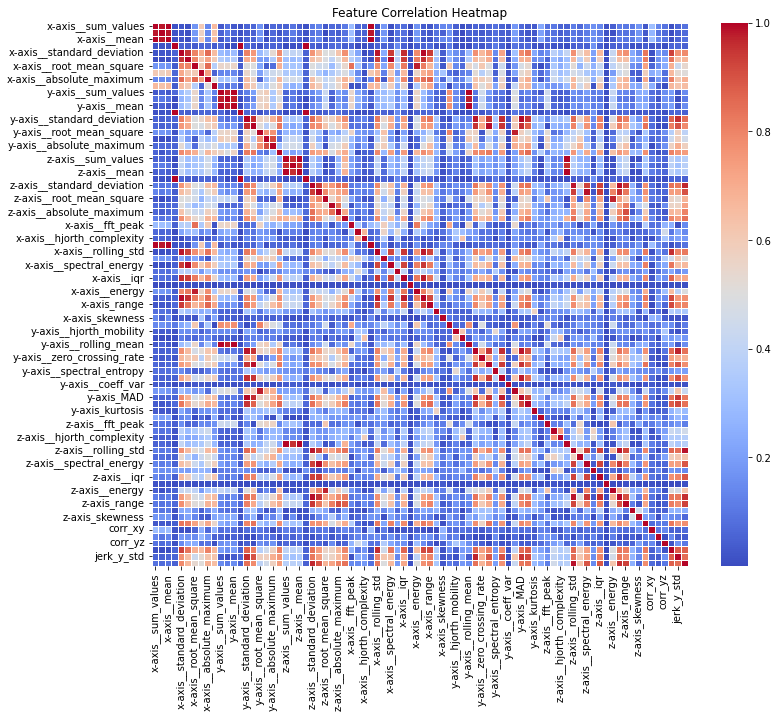

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load training dataset
train_file = "Updated_Metadata_2.csv"
df_train = pd.read_csv(train_file)

# Define target and ID columns
target_column = "activity"
id_column = "user_snippet"

# Drop target and ID from feature set
df_train_drop = df_train.drop(columns=[target_column, id_column])

# Compute absolute correlation matrix
correlation_matrix = df_train_drop.corr().abs()

# Save correlation matrix as CSV
correlation_matrix.to_csv("feature_correlation_matrix.csv")

# Plot heatmap of feature correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [2]:
metadata_df = pd.read_csv("Updated_Metadata_2.csv")
metadata_df["activity"].value_counts()

activity
Walking       2452
Jogging       1951
Upstairs       702
Downstairs     606
Sitting        321
Standing       278
Name: count, dtype: int64

## Feature Importance Check with RF

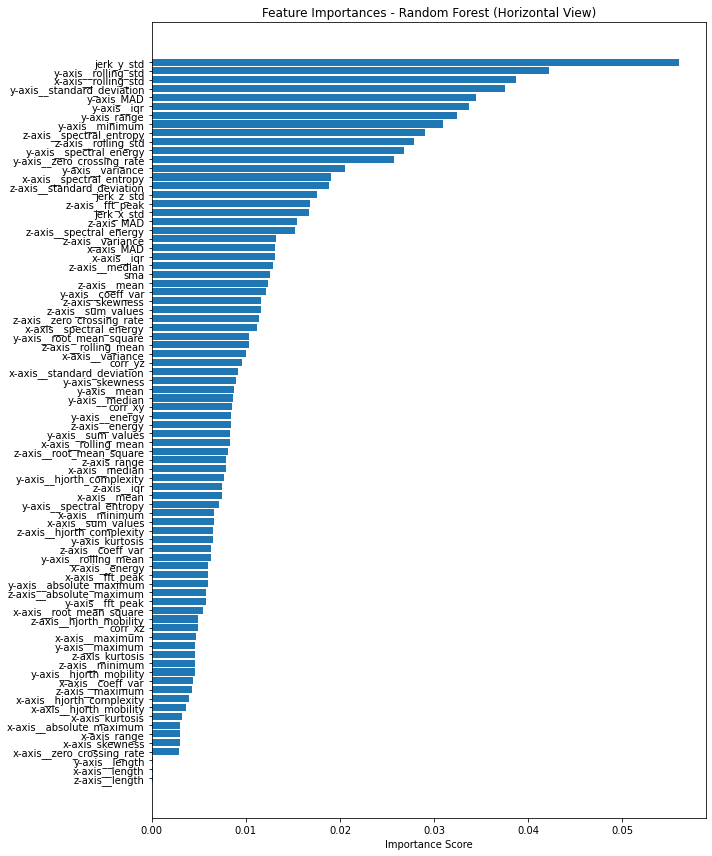

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Load your data
df = pd.read_csv("Updated_Metadata_2.csv")

# Split features and target
X = df.drop(columns=["user_snippet", "activity"])
y = LabelEncoder().fit_transform(df["activity"])

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
features = X.columns

# Create a DataFrame for easy sorting
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=True)  # Ascending for horizontal bar chart

# Plot horizontal bar chart
plt.figure(figsize=(10, 12))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance Score")
plt.title("Feature Importances - Random Forest (Horizontal View)")
plt.tight_layout()

# Save the plot
plt.savefig("feature_importances.png", dpi=300)

# Show the plot
plt.show()
